In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import chain
from sklearn.linear_model import LinearRegression
import os
import logging

In [2]:
from utils.DetectionTools import merge_close_points, get_detected_intervals
from utils.OutlierUtils import left_derivatives, get_region, remove_outliers_by_region, sanitize_response_name


# Indicate the path to your data file here

In [3]:
# Make sure to change this path to the location of your data file
# and that the there are single quotes around the path.
path_to_data = '/Users/bc/Library/CloudStorage/Box-Box/Bhagawat_Summer_Student/code_development/Final/data/Stds_060325.csv'

In [4]:
output_path = './output/'

In [5]:
# Import data
df = pd.read_csv(path_to_data)
t = df['Time']
df

,Replicate,Reading,Time,Ti -/48(Pulse/CPS),Cr -/52(Pulse/CPS),Mn -/55(Pulse/CPS),Fe -/56(Pulse/CPS),Ni -/60(Pulse/CPS),Mo -/98(Pulse/CPS)
0,1,1,0.000,680.016184,1960.134465,4360.665438,30672.893611,13626.495751,80.000224
1,1,2,0.432,560.010976,2020.142824,3120.340741,30011.491058,12505.471144,40.000056
2,1,3,0.864,520.009464,1620.091859,3820.510802,30692.936590,13005.917693,100.000350
3,1,4,1.296,780.021295,2040.145666,3920.537898,30753.065696,12365.349250,40.000056
4,1,5,1.728,660.015246,1880.123712,3560.443631,31394.458558,13586.457643,40.000056
...,...,...,...,...,...,...,...,...,...
6697,1,6698,2893.211,40.000056,140.000686,40.000056,11985.025321,1300.059153,880.027105
6698,1,6699,2893.643,40.000056,320.003584,20.000014,12085.109584,1740.105972,1000.035001
6699,1,6700,2894.075,0.000000,180.001134,20.000014,13366.250059,1140.045488,940.030927
6700,1,6701,2894.507,20.000014,240.002016,40.000056,11864.925130,1600.089605,1020.036415


# Select the response column index
### where 1 is the first column after 'Time', 2 is the second, etc.

In [6]:
response_index = 1 # Change this to select the response column

In [7]:
# set the response data
if not df.columns.empty:
    cols_to_drop = []
    if 'Time' in df.columns:
        cols_to_drop.append('Time')
    if 'Replicate' in df.columns:
        cols_to_drop.append('Replicate')
    if 'Reading' in df.columns:
        cols_to_drop.append('Reading')

    responses = df.drop(columns=cols_to_drop)
    if responses.empty and not df.empty: # Check if all columns were dropped, and df wasn't empty initially
        raise ValueError("All columns were identified as non-response columns. No response data left.")
else:
    raise ValueError("DataFrame has no columns.")

response = responses.columns[response_index-1]
response_data = df[response]

In [8]:
# creat output folder
os.makedirs(f'{output_path}', exist_ok=True)

#create dataset path
dataset_name = path_to_data.split('/')[-1].split('.')[0]
dataset_path = f'{output_path}/{dataset_name}'

os.makedirs(dataset_path, exist_ok=True)

In [9]:
safe_name = sanitize_response_name(response)
figure_dir = f'{dataset_path}/figures/{safe_name}'
os.makedirs(figure_dir, exist_ok=True)

In [10]:
# Identifying shifts with k-means
X = collections.deque(t)
Y = collections.deque(response_data)

In [11]:
# Normalize time
df['Time'] = df['Time'] - df['Time'].min()
df = df.loc[:, df.columns.intersection(['Time',f'{response}'])]
df_response_idxMax = df.idxmax()[response]
df = df.iloc[:df_response_idxMax+1]

df

,Time,Ti -/48(Pulse/CPS)
0,0.000,680.016184
1,0.432,560.010976
2,0.864,520.009464
3,1.296,780.021295
4,1.728,660.015246
...,...,...
4603,1988.569,225688.768013
4604,1989.001,229386.975505
4605,1989.433,226481.161091
4606,1989.865,224002.538144


In [12]:
%matplotlib qt

clicked_coordinates = None # Variable to store the click location
left_derivatives_df = left_derivatives(df['Time'].to_numpy(), df[response].to_numpy())


def onclick(event):
    global clicked_coordinates # Declare it global to modify the outside variable
    if event.xdata is not None and event.ydata is not None:
        clicked_coordinates = (event.xdata, event.ydata)
        logging.info(f"Clicked at data coordinates: x={event.xdata}, y={event.ydata}")
        plt.close(fig) # Close the window

    else:
        logging.info("Click was outside the plot area.")

fig, ax1 = plt.subplots(figsize=(18, 12), layout='constrained') # Increased figure size for clarity
plt.scatter(df['Time'], df[response])

# Save derivative and data pllot
plt.savefig(f'{output_path}/{dataset_name}/Derivative-Data-Plot', bbox_inches='tight',dpi=300)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Now your loop can run while the plot is interactive
logging.info("Waiting for a click...")
start_time = time.time()
timeout_seconds = 1000 # Your desired timeout

while True:
    if clicked_coordinates:
        logging.info(f"Click detected at: {clicked_coordinates}")
        break
    if (time.time() - start_time) > timeout_seconds:
        logging.info('Timed out. No click detected within the specified time.')
        break
    plt.pause(0.1) # Process GUI events for a short period
                   # This is crucial for interactive mode to work
plt.ioff() # Turn off interactive mode
plt.show() # Keep the plot open until manually closed after the loop

INFO: Waiting for a click...
INFO: Clicked at data coordinates: x=342.7485080800051, y=408.08239420079553
INFO: Click detected at: (342.7485080800051, 408.08239420079553)


In [13]:
%matplotlib inline

# After the window is closed, you can access the stored coordinates
if clicked_coordinates:
    logging.info(f"The final stored coordinates are: {clicked_coordinates}")
else:
    logging.info("No valid click was registered before the window closed.")

first_region = (np.array([0]).astype(float)[0], clicked_coordinates[0])
first_region

INFO: The final stored coordinates are: (342.7485080800051, 408.08239420079553)


(0.0, 342.7485080800051)

In [14]:
# Get left derivatives
left_derivatieves_df = left_derivatives_df[left_derivatives_df['Time'] > first_region[1]]
left_derivatives_df.set_index(['Time'], inplace=True)
left_derivatives_df

,Y,Left_Derivative
Time,,
0.000,680.016184,NaN
0.432,560.010976,-277.789834
0.864,520.009464,-92.596093
1.296,780.021295,601.879237
1.728,660.015246,-277.791778
...,...,...
1988.569,225688.768013,-26253.401330
1989.001,229386.975505,8560.665492
1989.433,226481.161091,-6726.422254


In [15]:
# Define the first region
mask1 = (left_derivatives_df['Left_Derivative'] > left_derivatives_df['Y'])
shifts = left_derivatives_df[mask1]
mask2 = (shifts.index > first_region[1])
shifts = shifts[mask2]

shifts = list(shifts.index)

shifts

[590.565, 806.141, 1183.723, 1528.904, 1883.157]

In [26]:
detected_intervals = get_detected_intervals(shifts)
detected_intervals.append((first_region[1], detected_intervals[0][0]))
detected_intervals.append((first_region[0], first_region[1])) # Add the first region
detected_intervals = sorted(detected_intervals)

detected_intervals.append((detected_intervals[-1][1], df['Time'].max())) # Add the last region
detected_intervals


[(0.0, 342.7485080800051),
 (342.7485080800051, 590.565),
 (590.565, 806.141),
 (806.141, 1183.723),
 (1183.723, 1528.904),
 (1528.904, 1883.157),
 (1883.157, 1990.297)]

# Select a p value here

In [27]:
p = 70 # Change this to select the p value for merging close points

In [28]:
merged_points = merge_close_points(df=df, regions=detected_intervals, p=p, response=response)
merged_points_list = sorted(list(set(tuple(chain.from_iterable(merged_points)))))
merged_points

Starting merge with 7 regions, p-value: 70
First region: (0.0, 342.7485080800051), median: 640.014336321134
Comparing region 1: (342.7485080800051, 590.565), median: 4840.82003491391
  -> is_mergeable(640.01, 4840.82, 70) = False
  -> Added region to merged list: (0.0, 342.7485080800051)
Comparing region 2: (590.565, 806.141), median: 9443.12000685026
  -> is_mergeable(4840.82, 9443.12, 70) = False
  -> Added region to merged list: (342.7485080800051, 590.565)
Comparing region 3: (806.141, 1183.723), median: 23278.9513943301
  -> is_mergeable(9443.12, 23278.95, 70) = False
  -> Added region to merged list: (590.565, 806.141)
Comparing region 4: (1183.723, 1528.904), median: 45953.7926001573
  -> is_mergeable(23278.95, 45953.79, 70) = False
  -> Added region to merged list: (806.141, 1183.723)
Comparing region 5: (1528.904, 1883.157), median: 89740.9880075504
  -> is_mergeable(45953.79, 89740.99, 70) = False
  -> Added region to merged list: (1183.723, 1528.904)
Comparing region 6: (188

[(0.0, 342.7485080800051),
 (342.7485080800051, 590.565),
 (590.565, 806.141),
 (806.141, 1183.723),
 (1183.723, 1528.904),
 (1528.904, 1883.157),
 (1883.157, 1990.297)]

## Final Plot

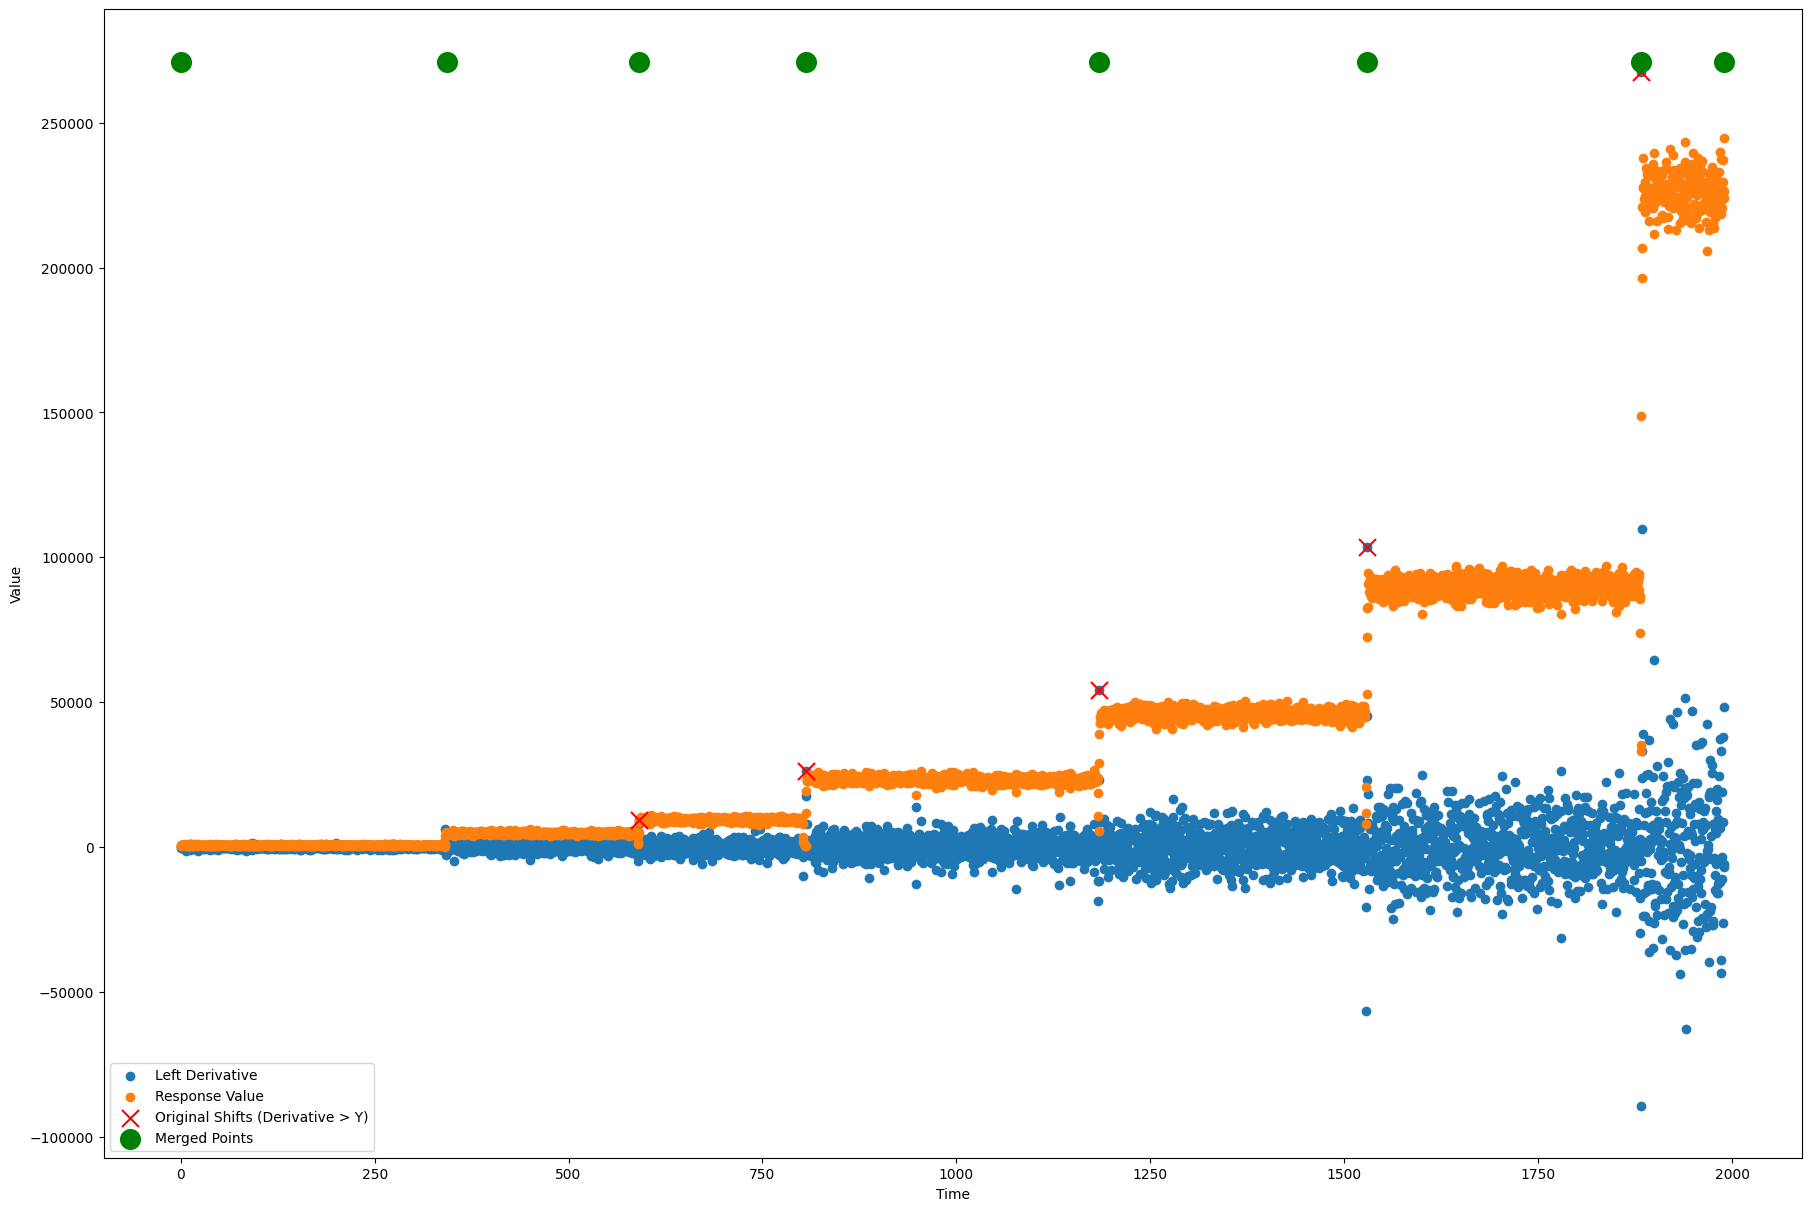

In [29]:
fig, ax1 = plt.subplots(figsize=(18, 12), layout='constrained')

# Plot original data and derivatives
ax1.scatter(left_derivatives_df.index, left_derivatives_df['Left_Derivative'], label='Left Derivative')
ax1.scatter(df['Time'], df[response], label='Response Value')

# Plot the original 'shifts' as red 'x' marks
ax1.scatter(shifts,
            left_derivatives_df.loc[shifts, 'Left_Derivative'],
            marker='x', color='red', s=150, zorder=4, label='Original Shifts (Derivative > Y)')


# Add the merged points to the plot as green circles
ax1.scatter(merged_points_list, [ax1.get_ylim()[1] * 0.95] * len(merged_points_list),
            marker='o', color='green', s=200, zorder=5, label='Merged Points') # Plot high up to be visible'

ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()
plt.savefig(f'{figure_dir}/Regional-Final.png',bbox_inches='tight',dpi=300)
plt.show()


get_region called with t0=0.0, tf=342.7485080800051. Filtered DataFrame shape: (794, 2)
get_region called with t0=15.0, tf=327.7485080800051. Filtered DataFrame shape: (724, 2)
get_region called with t0=342.7485080800051, tf=590.565. Filtered DataFrame shape: (574, 2)
get_region called with t0=357.7485080800051, tf=575.565. Filtered DataFrame shape: (504, 2)
get_region called with t0=590.565, tf=806.141. Filtered DataFrame shape: (500, 2)
get_region called with t0=605.565, tf=791.141. Filtered DataFrame shape: (430, 2)
get_region called with t0=806.141, tf=1183.723. Filtered DataFrame shape: (875, 2)
get_region called with t0=821.141, tf=1168.723. Filtered DataFrame shape: (805, 2)
get_region called with t0=1183.723, tf=1528.904. Filtered DataFrame shape: (800, 2)
get_region called with t0=1198.723, tf=1513.904. Filtered DataFrame shape: (730, 2)
get_region called with t0=1528.904, tf=1883.157. Filtered DataFrame shape: (821, 2)
get_region called with t0=1543.904, tf=1868.157. Filtered

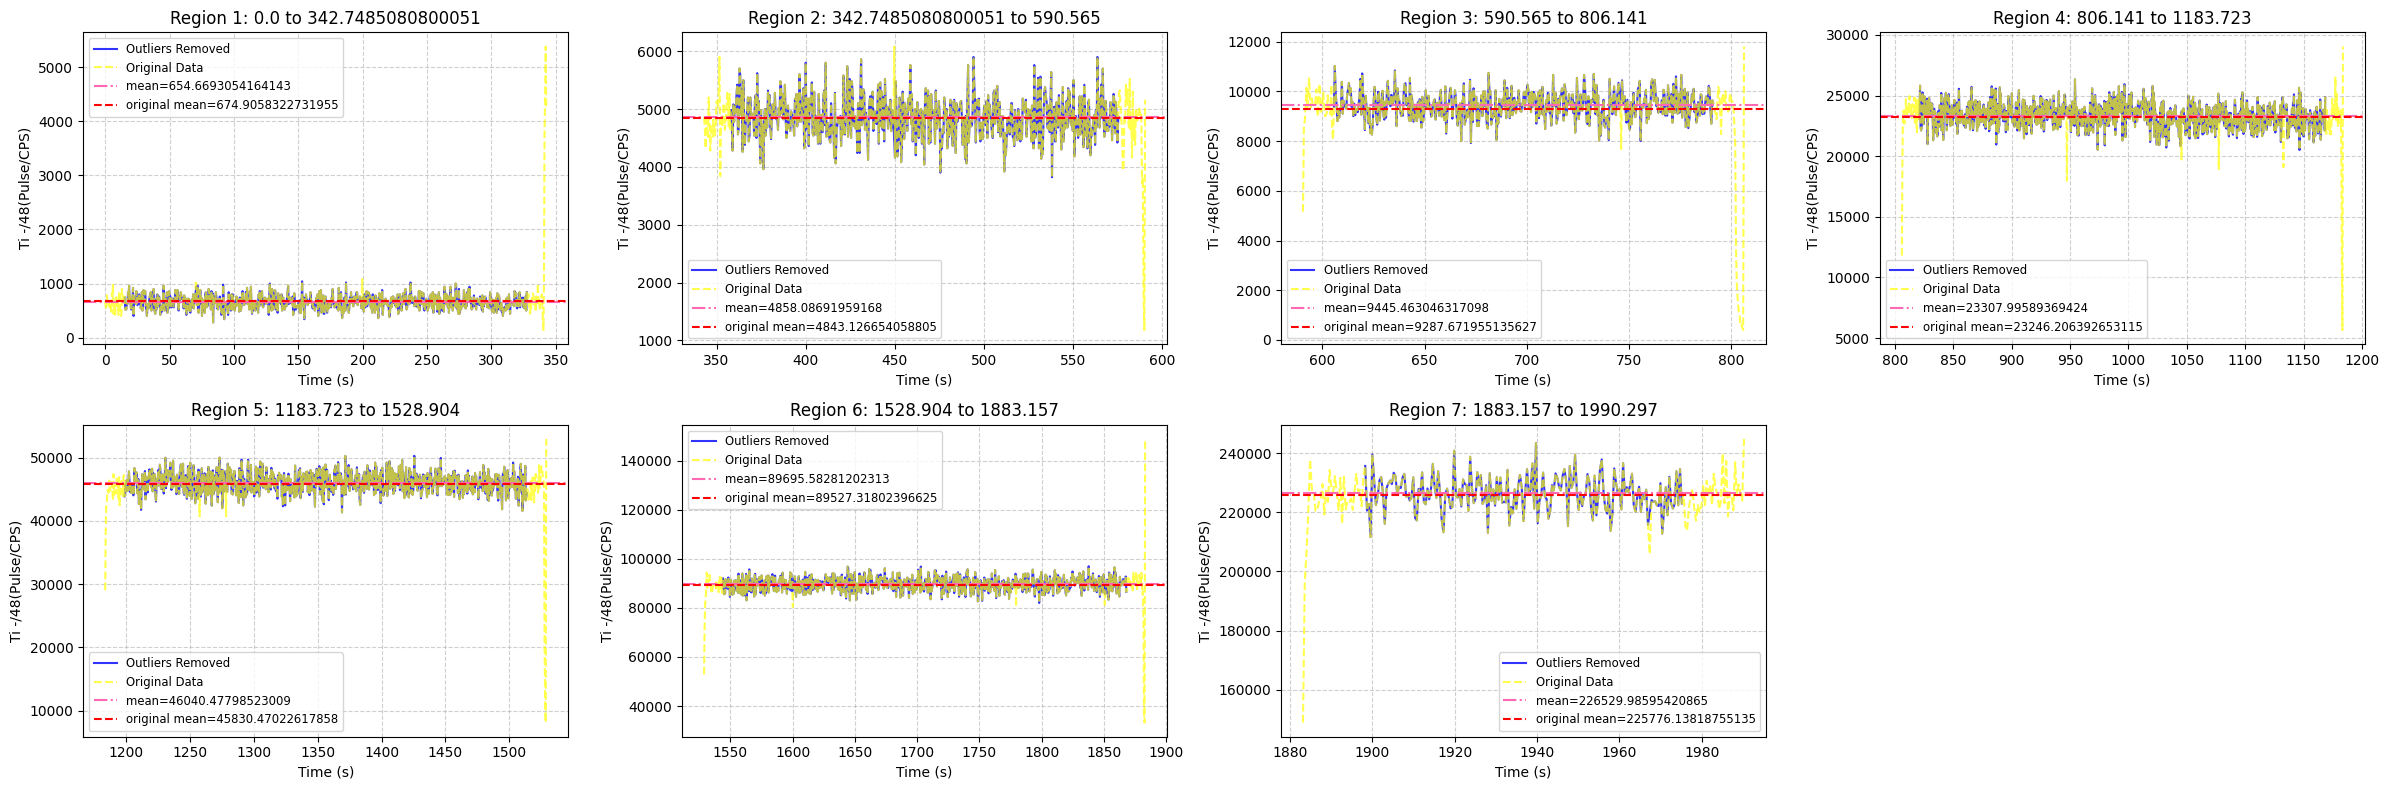

In [30]:
regional_means = []

num_regions = len(detected_intervals)
ncols = 4 # You can change the number of columns
nrows = (num_regions + ncols - 1) // ncols

offset = 15 # 15 seconds offset to 

final_df = pd.DataFrame()


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4 * nrows))
axes_flat = axes.flatten() # Flatten the 2D axes array for easier iteration
for i, (x0, x1) in enumerate(detected_intervals):
    # Get the current Axes object for this iteration from the flattened array
    if i < len(axes_flat):
        current_ax = axes_flat[i]
    else:
        # This case should ideally not happen if nrows is calculated correctly,
        # but provides a safeguard if more plots are attempted than subplots available.
        logging.warning(f" Not enough subplots for region {i+1}. Skipping plot.")
        continue
    

    # Call your outlier removal function for the current region
    original_region_data = get_region(df=df, t0=x0, tf=x1)
    Y_prime = remove_outliers_by_region(R=(x0 + offset, x1 - offset), response_column_name=response, Y=df)

    # logging.info(f'New Region {i+1}: ({val['Start'] + offset}, {val['End'] - offset})')

    # Plot the results on the current subplot
    if not Y_prime.empty:
        # Plot the data after outlier removal
        current_ax.plot(Y_prime['Time'], Y_prime[response], label='Outliers Removed', color='blue', alpha=0.8)
        
        # Plot original data for comparison (only within the current region)

        
        current_ax.plot(original_region_data['Time'], original_region_data[response],
                        '--', color='yellow', alpha=0.7, label='Original Data')
        
        region_mean = Y_prime[response].mean()
        original_mean = original_region_data[response].mean()
        
        current_ax.axhline(y=region_mean, color='#FF69B4', linestyle='-.', label=f'mean={region_mean}')
        current_ax.axhline(y=original_mean, color='red', linestyle='--', label=f'original mean={original_mean}')

        regional_means.append(region_mean)
        
        current_ax.legend(fontsize='small')
    else:
        current_ax.text(0.5, 0.5, 'No Data or Outliers Removed\nfor this Region',
                        horizontalalignment='center', verticalalignment='center',
                        transform=current_ax.transAxes, fontsize=10, color='red')
        continue

    # Set titles and labels for the current subplot
    current_ax.set_title(f'Region {i+1}: {x0} to {x1}')
    current_ax.set_xlabel('Time (s)')
    current_ax.set_ylabel(f'{response}')
    current_ax.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability

    final_df = pd.concat([final_df, Y_prime], ignore_index=True)



# This prevents empty plots from appearing if your `area_df` has fewer regions than the grid size
for j in range(num_regions, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.savefig(f'{figure_dir}/regions.png',
             bbox_inches='tight',
             dpi=300)
plt.tight_layout() # Automatically adjust subplot parameters for a tight layout
plt.show() # Display the plot
    
# plt.tight_layout()
# plt.show()

In [31]:
final_df = final_df.sort_index()
final_df

,Time,Ti -/48(Pulse/CPS)
0,15.120,740.019166
1,15.552,520.009464
2,15.984,540.010206
3,16.416,520.009464
4,16.848,640.014336
...,...,...
4104,1973.449,222864.952445
4105,1973.881,233919.590821
4106,1974.313,222357.130706
4107,1974.745,234631.117377


# Indicate concentrations here

In [ ]:
concentrations = []

[654.6693054164143,
 4858.08691959168,
 9445.463046317098,
 23307.99589369424,
 46040.47798523009,
 89695.58281202313,
 226529.98595420865]

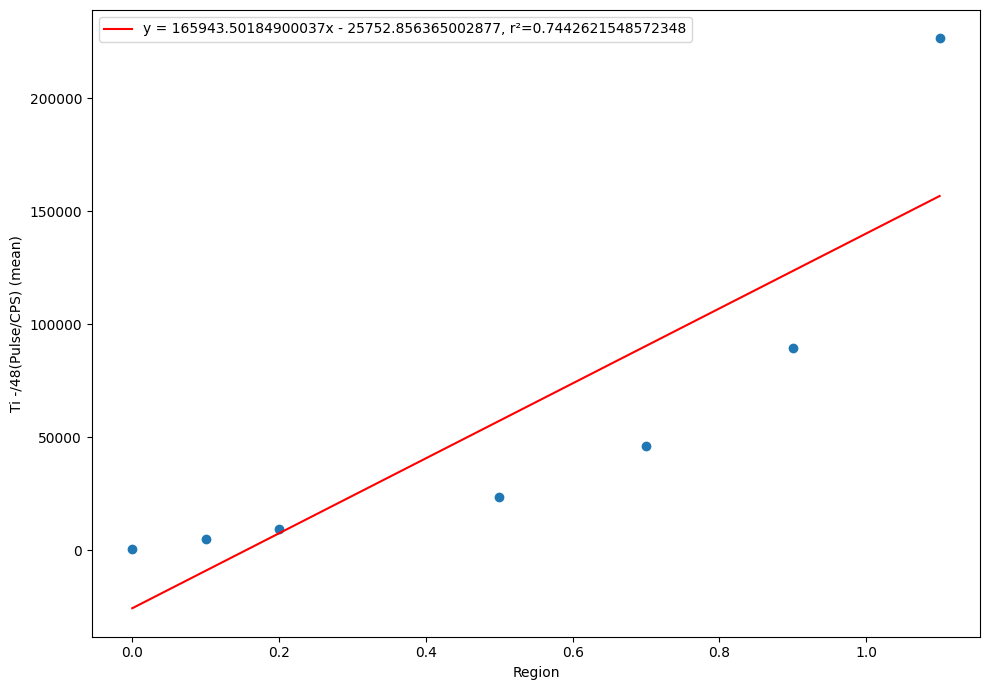

In [32]:
# Plot regional means
labels = np.array([concentrations])/10
data = pd.DataFrame(regional_means, labels)

fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the bars
ax1.scatter(data.index, data.values)  # Convert index to string for proper label display
m,b = np.polyfit(labels, regional_means, 1)

model = LinearRegression()

X = labels.reshape(-1, 1)
y = np.array(regional_means)

model.fit(X,y)

r_squared = model.score(X,y)


# Find regression equation
if b >= 0:
    line_label = f'y = {m}x + {b}'
else:
    line_label = f'y = {m}x - {-b}' # Use -b to show a positive number after the minus sign

ax1.plot(labels, m*labels + b, color='red', label=f'{line_label}, r²={r_squared}')


plt.legend()

ax1.set_xlabel('Region')
ax1.set_ylabel(f'{response} (mean)')



plt.tight_layout()
plt.savefig(f'{figure_dir}/Regression-Plot.png', bbox_inches='tight',dpi=300)
plt.show()


$$ \textit{Opus ex amino, } \\ \text{Bhagawat Chapagain} $$